# Exercise - Titanic - Decision trees

We will **illustrate decision trees using the Titanic data.** The goal is to **build a model that can predict whether a passenger from the Titanic survived or not based on several features** including its age, sex and passenger class (1st, 2nd or 3rd).

### Data preprocessing

Let's start by loading the data from the 'titanic.csv' file

In [4]:
import pandas as pd

# Load data
data_df = pd.read_csv(r'Course 4\titanic.csv')

# First five rows
data_df.head()

,name,pclass,age,sex,survived
0,"Hirvonen, Miss Hildur E",3rd,2,female,0
1,"Van Impe, Miss Catharine",3rd,10,female,0
2,"Sjostedt, Mr Ernst Adolf",2nd,59,male,0
3,"Fortune, Mr Mark",1st,64,male,0
4,"Ware, Mr William J",2nd,23,male,0


In [5]:
# One-hot encoding
encoded_df = pd.get_dummies(data_df, columns=['pclass'])

# Encode binary variable with 0s and 1s
encoded_df['sex'] = encoded_df['sex'].replace({
    'male':0,
    'female':1
})

# Frit five rows
encoded_df.head()

,name,age,sex,survived,pclass_1st,pclass_2nd,pclass_3rd
0,"Hirvonen, Miss Hildur E",2,1,0,0,0,1
1,"Van Impe, Miss Catharine",10,1,0,0,0,1
2,"Sjostedt, Mr Ernst Adolf",59,0,0,0,1,0
3,"Fortune, Mr Mark",64,0,0,1,0,0
4,"Ware, Mr William J",23,0,0,0,1,0


*In this code, we create a dummy variable for each passenger class using the $get_dummies()$ function from Pandas, and we replace the $male$ and $female$ values with numerical 0/1 labels. The $encoded_df$ DataFrame now only contains numerical values (except the $name$ variable, but we will drop it before building the tree).*

In [6]:
# we can now create the X/y arrays

import numpy as np

# Select features
X = encoded_df.drop(columns=['name','survived']).values
y = encoded_df['survived'].values

### Scikit-learn DecisionTreeClassifier

Scikit-learn provides a $DecisionTreeClassifier$ estimator to build decision trees. Let's start with **a simple decision tree with a depth of one that minimizes the Gini impurity measure at each split**.

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=0)

The estimator shuffles the features at each split. Hence, the results may vary when there are ties (two splits with the same impurity score). In the code from above, we set the random_state parameter to zero to fix the results.

In [8]:
# Fit decision tree
dt.fit(X, y)

# Get score
dt.score(X, y)

0.7791005291005291

**We get an accuracy around 78% which is already much better than the "most-frequent" baseline at 58% (below).**

In [9]:
pd.value_counts(y, normalize=True)

0    0.585979
1    0.414021
dtype: float64

### Visualize decision trees

One of the **main advantages of decision trees is that they are easy to interpret**.

* Each node corresponds to a simple rule.
* The most important ones are at the top of the decision tree.

We can visualize them using a library called **Graphviz**. Scikit-learn implements an $export_graphviz()$ function to export decision tree estimators into the Graphviz $.dot$ format.

In [10]:
from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    feature_names=encoded_df.drop(columns=['name','survived']).columns, class_names=['died','survived'],
    filled=True, rounded=True, proportion=True)

In this code, we create a $dot_data$ variable from our decision tree $dt.$ This variable contains all the information to plot our decision tree. Note that the function provides many arguments to customize its appearance and to specify what information it contains. In our case, there are three important arguments.

* $feature_names$ - the names of the features in $X$
* $class_names$ - the names of the classes in $y$
* $proportion=True$ - to include the proportion of samples in each node

Note that we set the feature names using the features variable from above ($encoded_df$ without its $name$ and $survived$ columns). We won't go into the details of each argument, but you can take a look at this page if you want to learn more about them.

To visualize the decision tree, we need to load it into a $Source$ object from the Graphviz library.

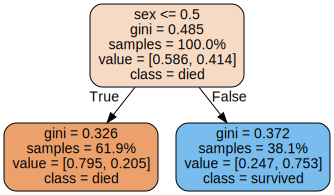

In [11]:
import graphviz

# Display decision tree
graphviz.Source(dot_data)

The graph encodes classes using colors. **Nodes with a majority of samples labeled with "survived" appear in blue and nodes with a majority of samples labeled with "died" in orange**. Each node contains the following information.

* **gini** - the impurity measure at this node
* **samples** - the percentage of samples in this node
* **value** - the probabilities for each class
* **class** - the class with the highest probability

**The decision tree splits the data into two groups using a single rule on the sex of the passengers. This feature is the most important one according to the Gini impurity measure.** Note that the node splits the samples by setting a threshold on the numerical label of the sex feature. Entries encoded with a zero (male) are in the left leaf and entries encoded with a one (female) are in the right leaf.

According to the **samples entries** in the image from above, there are respectively 61.9% and 38.1% of the samples in the left and right leaves. We can verify that using the value_counts() function from Pandas.

In [12]:
# Proportion of sample by sex
pd.value_counts(data_df['sex'], normalize=True)

male      0.619048
female    0.380952
Name: sex, dtype: float64

The **value entries in each leaf indicate the proportion of samples in each class**. For instance, the left leaf has 79.5% of samples labeled with "died" and the remaining 20.5% labeled with "survived". Again, we can verify that using the crosstab() function from Pandas.

In [13]:
# Cross tabulation of sex and survived
crosstab = pd.crosstab(
    index=data_df['sex'],
    columns=data_df['survived'],
    normalize='index' # Normalize by sex
)
crosstab

survived,0,1
sex,,
female,0.246528,0.753472
male,0.794872,0.205128


**The function groups the entries by sex and survival and returns the number of entries in each group, normalized by sex.**

*The first row corresponds to the probabilities in the right leaf and the second row to the probabilities in the left one. Finally, let's use these probabilities to verify the Gini impurity values at each leaf.*

In [14]:
# Get p(survived) at each leaf
p_left = crosstab.loc['male', 1]
p_right = crosstab.loc['female', 1]

# Compute Gini impurity values
i_left = 2*p_left*(1-p_left)
i_right = 2*p_right*(1-p_right)
print('Gini impurity (left leaf): {:.3f}'.format(i_left))
print('Gini impurity (right leaf): {:.3f}'.format(i_right))

Gini impurity (left leaf): 0.326
Gini impurity (right leaf): 0.372


In this code, we get the probabilities of the positive class at each leaf and compute the Gini impurity values using the formula that we saw above.

#### Deeper trees

Öet's try to increase the depth of the tree to two with the $max_depth$ parameters.

In [15]:
# Create decision tree
dt_2 = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)

# Fit decision tree
dt_2.fit(X, y)

# Get score
dt_2.score(X, y)

0.8108465608465608

The accuracy is around 81% which is a bit better than before. Let's visualize the new decision tree.

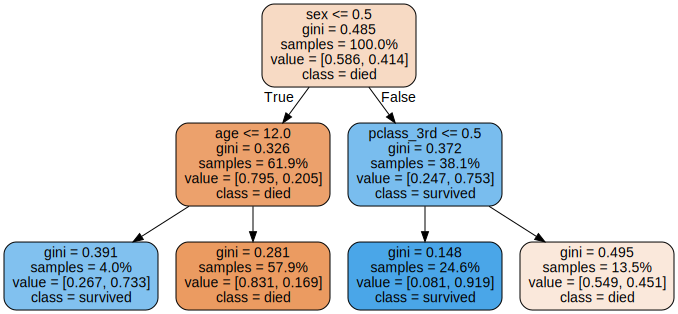

In [16]:
# Export decision tree
dot_data_2 = export_graphviz(
    dt_2, out_file=None,
    feature_names=encoded_df.drop(columns=['name','survived']).columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

# Display it
graphviz.Source(dot_data_2)

Again, one of the main advantages of the decision tree model is its **interpretability**. Here is a textual summary of the tree.

* **Most men perished but young boys survived**
* **Most women survived, but half of the women from the 3rd class perished**

However, **the complexity of the tree increases with its depth**, and it's easy to create a tree that **overfits**. For instance, let's remove the maximum depth criteria by setting it to $None$. This time, we will fit and evaluate the decision tree on different sets.

In [17]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Create decision tree
dt_max_depth = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=0)

# Fit decision tree
dt_max_depth.fit(X_tr, y_tr)

# Get train/test scores
print('Train accuracy: {:.3f}'.format(dt_max_depth.score(X_tr, y_tr)))
print('Test accuracy: {:.3f}'.format(dt_max_depth.score(X_te, y_te)))

Train accuracy: 0.870
Test accuracy: 0.784


As we can see, the decision tree correctly classifies 87% of the samples from the train set, but only 78.4% from the test set. **This is one of the main issues with decision trees. Small trees can be too simple (high bias) to model our data, and larger ones tend to overfit (high variance).**

In [18]:
# Export decision tree
#dot_data_max = export_graphviz(
#    dt_max_depth, out_file=None,
#    feature_names=encoded_df.drop(columns=['name','survived']).columns, class_names=['died', 'survived'],
#    filled=True, rounded=True, proportion=True   
#)

# Display it
#graphviz.Source(dot_data_max)

#### Summary

In this unit, we saw the basic idea behind decision trees and implemented one using $Scikit-learn$. Here are a few takeaways.

* **Decision trees minimize an impurity measure at each split.**
* **The complexity of a decision tree depends on its depth.**
* Scikit-learn $DecisionTreeClassifier$ estimator requires categorical features to be encoded with one-hot encoding.

**In practice, we use a decision tree when we want to build a simple model that we can easily visualize and interpret.** However, we will see in the next unit that **we can also combine large trees into a random forest to create more complex models.**

# Exercise - Spirals data set

The goal of this exercise is to experiment with the different classifiers below:

* Logistic regression
* k-NN
* Decision trees
* Random forests
* SVM with linear and RBF kernels

We will work on a data set with only two features such that we can visualize the classifiers by plotting their decision surfaces. The *decision_surface()* function is provided below to do that. For each classifier from above, we play with the different parameters (*max_depth*, *n_estimators*, *C*, *gamma*, and so on) and visualize their effect on the decision surface.

#### Data presentation

The data is made of two nested spirals with a thousand data points each.

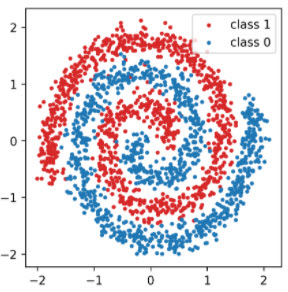

In [2]:
from IPython.display import Image
Image(filename='SVM7.jpg')

### Plot decision surface

Here is the *decision_surface()* function from the previous units. Since there are two thousand data points, we reduced the size of the markers in the plot to better visualize the two spirals i.e. *plt.scatter(.., s=6)* in the code below

In [50]:
import numpy as np

# Helper function
def decision_surface(ax, x1, x2, y, estimator):
    # Same scale for x- and y-axis
    ax.set_aspect('equal', adjustable='box')

    # Plot data points
    class1_idx = (y == 1)
    plt.scatter(x1[class1_idx], x2[class1_idx], color='C3', label='class 1', s=6)
    plt.scatter(x1[~class1_idx], x2[~class1_idx], color='C0', label='class 0', s=6)

    # Create a grid of values
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x_values = np.linspace(*xlim, num=500)
    y_values = np.linspace(*ylim, num=500)
    xx, yy = np.meshgrid(x_values, y_values)
    grid_points = np.c_[xx.flatten(), yy.flatten()]

    # Compute predictions
    preds = estimator.predict(grid_points)
    zz = preds.reshape(xx.shape)

    # Draw decision boundary
    plt.contour(xx, yy, zz, levels=[0.5], colors='gray')

    # Plot decision surface with level curves
    plt.contourf(xx, yy, zz, alpha=0.1, cmap=plt.cm.coolwarm)
    plt.legend()
    plt.show()

In [51]:
data = pd.read_csv('Course 4/spirals.csv')
print('Shape:',data.shape)
data.head()

Shape: (2000, 3)


,x1,x2,y
0,-0.952,0.721,0
1,-0.842,0.130,1
2,-0.225,0.375,1
3,0.535,-1.408,0
4,-0.867,1.642,1


In [52]:
X = data.drop(columns=['y']).values
y = data.y.values

In [58]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

print('X train:',X_tr.shape,'y train',y_tr.shape)
print('X test:',X_te.shape,'y test',y_te.shape)

X train: (1400, 2) y train (1400,)
X test: (600, 2) y test (600,)


### Baseline

In [79]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()

dummy.fit(X_tr, y_tr)

print('Baseline accuracy: {:.2f}'.format(dummy.score(X_te, y_te)))

Baseline accuracy: 0.49


### Logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [61]:
logreg = Pipeline([
    ('scaler',StandardScaler()),
    ('logistic',LogisticRegression())
])

In [66]:
logreg.fit(X_tr, y_tr)
logreg.score(X_te, y_te)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.69

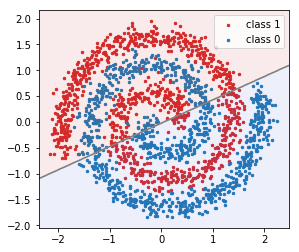

In [67]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, logreg)

In [80]:
from sklearn.model_selection import GridSearchCV

In [82]:
logreg.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logistic',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='warn',
             tol=0.0001, verbose=0, warm_start=False))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__max_iter': 100,


In [90]:
Cs = np.logspace(-10,10,10)
grid = [{
    'logistic__C':Cs,
    'logistic__multi_class': ['ovr'],
    'logistic__solver':  ['liblinear']
},{
    'logistic__C':Cs,
    'logistic__multi_class': ['multinomial'], # softmax
    'logistic__solver':  ['saga']
}]
logreg_gscv = GridSearchCV(logreg,param_grid=grid, refit=True, cv=10, return_train_score=True) # cv stands for cross-validation

In [91]:
# Fit to train set
logreg_gscv.fit(X_tr, y_tr)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'logistic__C': array([1.00000e-10, 1.66810e-08, 2.78256e-06, 4.64159e-04, 7.74264e-02,
       1.29155e+01, 2.15443e+03, 3.59381e+05, 5.99484e+07, 1.00000e+10]), 'logistic__multi_class': ['ovr'], 'logistic__solver': ['liblinear']}, {'logistic__C': array([1.00000e-10, 1.66810e-08, 2.78256e-06, 4.64159e-04, 7.74264e-02,
       1.29155e+01, 2.15443e+03, 3.59381e+05, 5.99484e+07, 1.00000e+10]), 'logistic__multi_class': ['multinomial'], 'logistic__solver': ['saga']}],
       pr

In [118]:
# Get results
logreg_results = pd.DataFrame({
    'multiclass':logreg_gscv.cv_results_['param_logistic__multi_class'],
    'solver':logreg_gscv.cv_results_['param_logistic__solver'],
    'c':logreg_gscv.cv_results_['param_logistic__C'],
    'mean_tr_score':logreg_gscv.cv_results_['mean_train_score'],
    'mean_te_score':logreg_gscv.cv_results_['mean_test_score'],
    'std_te_scopre':logreg_gscv.cv_results_['std_test_score']
})

In [96]:
logreg_results.sort_values(by='mean_te_score', ascending=False).head(10)

,multiclass,solver,c,mean_tr_score,mean_te_score,std_te_scopre
0,ovr,liblinear,1e-10,0.663176,0.666429,0.028229
8,ovr,liblinear,5.99484e+07,0.668334,0.666429,0.033347
18,multinomial,saga,5.99484e+07,0.668334,0.666429,0.033347
17,multinomial,saga,359381,0.668255,0.666429,0.033347
16,multinomial,saga,2154.43,0.668334,0.666429,0.033347
15,multinomial,saga,12.9155,0.668175,0.666429,0.033347
1,ovr,liblinear,1.6681e-08,0.663176,0.666429,0.028229
9,ovr,liblinear,1e+10,0.668334,0.666429,0.033347
19,multinomial,saga,1e+10,0.668255,0.666429,0.033347
7,ovr,liblinear,359381,0.668334,0.666429,0.033347


In [145]:
logreg_accuracy = logreg_gscv.score(X_te, y_te)
print('Accuracy Logisitc regression:',logreg_accuracy)

Accuracy Logisitc regression: 0.68


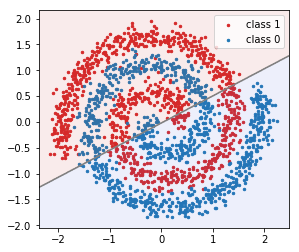

In [103]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, logreg_gscv)

### K-NN Classifier

In [110]:
from sklearn.neighbors import KNeighborsClassifier

In [111]:
knn = Pipeline([
    ('sclaer',StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [112]:
knn.fit(X_tr, y_tr)
knn.score(X_te, y_te)

0.9816666666666667

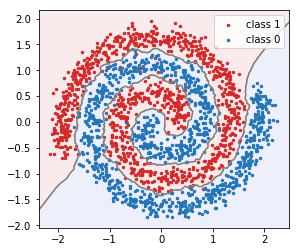

In [113]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, knn)

In [114]:
knn.get_params()

{'memory': None,
 'steps': [('sclaer',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=None, n_neighbors=5, p=2,
              weights='uniform'))],
 'sclaer': StandardScaler(copy=True, with_mean=True, with_std=True),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform'),
 'sclaer__copy': True,
 'sclaer__with_mean': True,
 'sclaer__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [137]:
grid = {
    'knn__n_neighbors':[5,7,9,11,13,15],
    'knn__p':[1,2],
    'knn__weights':['uniform','distance']
}

In [138]:
knn_gscv = GridSearchCV(knn,param_grid=grid,refit=True,cv=10,return_train_score=True)
knn_gscv.fit(X_tr, y_tr)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sclaer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': [5, 7, 9, 11, 13, 15], 'knn__p': [1, 2], 'knn__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [139]:
knn_results = pd.DataFrame({
    'n':knn_gscv.cv_results_['param_knn__n_neighbors'],
    'p':knn_gscv.cv_results_['param_knn__p'],
    'w':knn_gscv.cv_results_['param_knn__weights'],
    'mean_te_score':knn_gscv.cv_results_['mean_test_score'],
    'mean_tr_score':knn_gscv.cv_results_['mean_train_score'],
    'std_te_score':knn_gscv.cv_results_['std_test_score']
})

In [140]:
knn_results.sort_values(by='mean_te_score', ascending=False).head()

,n,p,w,mean_te_score,mean_tr_score,std_te_score
22,15,2,uniform,0.975714,0.979762,0.010686
23,15,2,distance,0.975000,1.000000,0.011613
11,9,2,distance,0.974286,1.000000,0.010198
19,13,2,distance,0.973571,1.000000,0.011070
10,9,2,uniform,0.973571,0.980952,0.010087


In [144]:
print('Accuracy k-NN Classifier: {:.2f}'.format(knn_gscv.score(X_te, y_te)))

Accuracy k-NN Classifier: 0.99


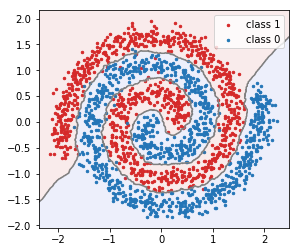

In [141]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, knn_gscv)

### Decision trees

In [146]:
from sklearn.tree import DecisionTreeClassifier

In [221]:
depth = np.linspace(1,50,25)
dt_results = []
for d in depth:
    dt = Pipeline([
        ('scaler',StandardScaler()),
        ('dt',DecisionTreeClassifier(criterion='gini',max_depth=d, random_state=0))
    ])
    
    dt.fit(X_tr, y_tr)
    
    dt_results.append({
        'depth':d,
        'accuracy_train':dt.score(X_tr, y_tr),
        'accuracy_test':dt.score(X_te, y_te)
    })
dt_results_df = pd.DataFrame(dt_results)

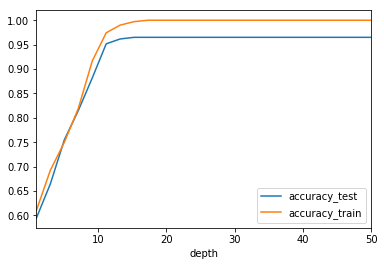

In [222]:
dt_results_df.plot(x='depth',y=['accuracy_test','accuracy_train'])
plt.show()

In [239]:
dt_final = DecisionTreeClassifier(criterion='gini',max_depth=20, random_state=0)

In [240]:
dt_final.fit(X_tr, y_tr)
print('Accuracy Decision tree (train): {:.2}'.format(dt_final.score(X_tr, y_tr)))
print('Accuracy Decision tree (test): {:.2}'.format(dt_final.score(X_te, y_te)))

Accuracy Decision tree (train): 1.0
Accuracy Decision tree (test): 0.96


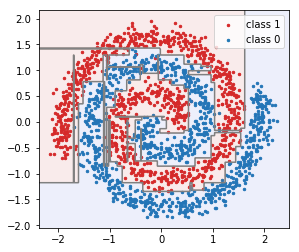

In [241]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, dt_final)

Accuracy Decision tree (train): 0.69
Accuracy Decision tree (test): 0.67


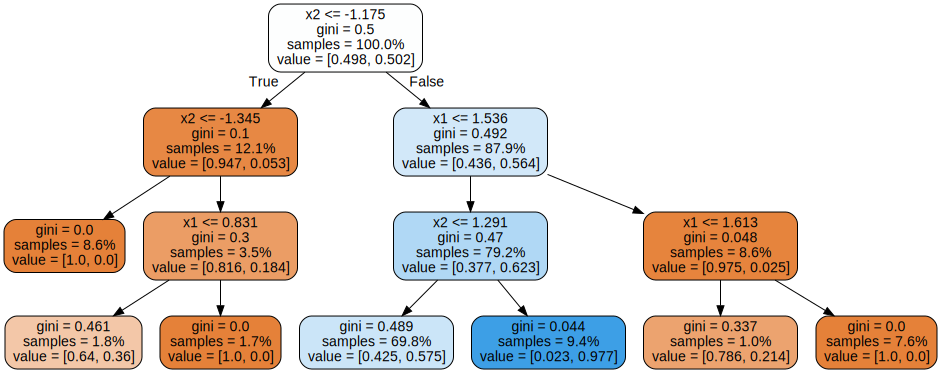

In [244]:
dt_3 = DecisionTreeClassifier(criterion='gini',max_depth=3, random_state=0)
dt_3.fit(X_tr, y_tr)
print('Accuracy Decision tree (train): {:.2}'.format(dt_3.score(X_tr, y_tr)))
print('Accuracy Decision tree (test): {:.2}'.format(dt_3.score(X_te, y_te)))

# Export decision tree
dot_data = export_graphviz(
    dt_3, out_file=None,
    feature_names=data.drop(columns=['y']).columns,
    filled=True, rounded=True, proportion=True   
)

# Display it
graphviz.Source(dot_data)

#### Random forest

In [245]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
forest = RandomForestClassifier()

In [248]:
forest.fit(X_tr, y_tr)
forest.score(X_te, y_te)

0.965

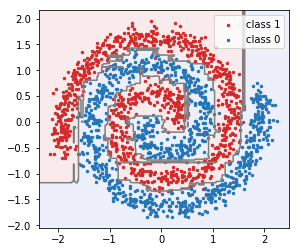

In [249]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, forest)

In [250]:
forest = RandomForestClassifier(n_estimators=1, criterion='gini', max_depth=10)
forest.fit(X_tr, y_tr)
forest.score(X_te, y_te)

0.8966666666666666

In [253]:
estimator = [1,3,5,7,9,11]
depth = [5,10,15,20,25]
forest_results = []
for e in estimator:
    for d in depth:
        forest = RandomForestClassifier(n_estimators=e, criterion='gini', max_depth=d)
        forest.fit(X_tr, y_tr)
        forest_results.append({
            'trees':e,
            'depth':d,
            'accuracy_train': forest.score(X_tr, y_tr),
            'accuracy_test': forest.score(X_te, y_te)
        })
forest_results_df = pd.DataFrame(forest_results)

In [257]:
forest_results_df.sort_values(by=['trees','depth'], ascending=False).tail(10)

,accuracy_test,accuracy_train,depth,trees
9,0.940000,0.990000,25,3
8,0.963333,0.991429,20,3
7,0.955000,0.993571,15,3
6,0.943333,0.962857,10,3
5,0.760000,0.777857,5,3
4,0.948333,0.977857,25,1
3,0.925000,0.962857,20,1
2,0.898333,0.930000,15,1
1,0.915000,0.925000,10,1
0,0.683333,0.715714,5,1


In [259]:
forest_results_df.sort_values(by='accuracy_test', ascending=False).head()

,accuracy_test,accuracy_train,depth,trees
12,0.973333,0.994286,15,5
19,0.973333,0.998571,25,7
24,0.973333,0.997143,25,9
27,0.971667,0.998571,15,11
17,0.971667,0.995000,15,7


In [263]:
forest_final = RandomForestClassifier(n_estimators=5, criterion='gini', max_depth=15)
forest_final.fit(X_tr, y_tr)
print('Accuracy RandomForest (train) {:.2}'.format(forest_final.score(X_tr, y_tr)))
print('Accuracy RandomForest (test) {:.2}'.format(forest_final.score(X_te, y_te)))

Accuracy RandomForest (train) 0.99
Accuracy RandomForest (test) 0.96


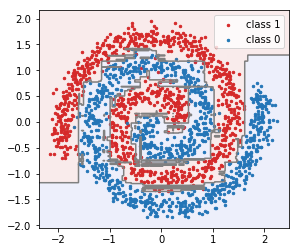

In [264]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, forest_final)

### SVM with linear and RBF kernels

In [285]:
from sklearn.svm import LinearSVC

# Create SVM with linear kernel
linear_svc = LinearSVC(C=1)

# Fit estimator
linear_svc.fit(X_tr, y_tr)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [286]:
linear_svc.score(X_te, y_te)

0.6883333333333334

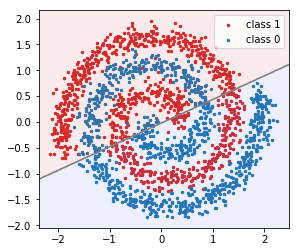

In [287]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, linear_svc)

In [305]:
from sklearn.svm import SVC

svc = SVC(C=1,kernel='rbf',gamma=1)
svc.fit(X_tr, y_tr)
svc.score(X_te, y_te)

0.9233333333333333

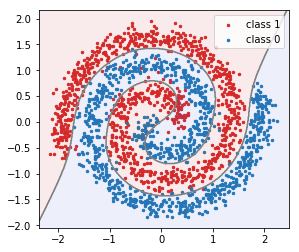

In [306]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, svc)

In [311]:
Cs = [0.1,1,10,100]
gammas = [1,10,100,1000]
svc_results  = []
for c in Cs:
    for g in gammas:
        svc = SVC(C=c, kernel='rbf', gamma=g)
        svc.fit(X_tr, y_tr)
        svc_results.append({
            'C':c,
            'gamma':g,
            'accuracy_train':svc.score(X_tr, y_tr),
            'accuracy_test':svc.score(X_te, y_te)
        })
svc_results_df = pd.DataFrame(svc_results)

In [312]:
svc_results_df.sort_values(by='accuracy_test', ascending=False).head()

,C,accuracy_test,accuracy_train,gamma
1,0.1,0.985000,0.980714,10
9,10.0,0.981667,0.990714,10
12,100.0,0.981667,0.980000,1
5,1.0,0.980000,0.982857,10
6,1.0,0.978333,0.992857,100


In [314]:
svc_final = SVC(C=0.1, kernel='rbf', gamma=10)
svc_final.fit(X_tr, y_tr)
print('Accuracy SVC (train): {:.2}'.format(svc_final.score(X_tr, y_tr)))
print('Accuracy SVC (test): {:.2}'.format(svc_final.score(X_te, y_te)))

Accuracy SVC (train): 0.98
Accuracy SVC (test): 0.98


### Quizz

Are there classifiers that cannot work with tihs data? Explain why.

**Greg:** Yes, LogisticRegression and Linear SVC. Both classifiers are Linear classifiers and can't predict outisde of linear classification. When plotting decision surface this can be easily identified

**Solution:** As we saw in the course, logistic regressions and linear SVMs can only perform linear classification.

By looking at the decision surfaces, what is the best classifier? Explain why.

**Greg:** Both K-NN and SVC with RBF kernels have good results, however SVC with RBF kernels is even more smooth. Those two classifiers use distance to other data points and therefore are better at classifying those kind of data sets

**Solution:** The RBF SVM and k-NN classifiers seem to generalize well from the data set. The SVM one has a particularly smooth decision boundary.